#### Loading saved data from joblib

In [30]:
# To get the folder where the script is running
import os

print("Current directory:", os.getcwd())

folder = r'C:/Users/FFFO CASHIER PT/OneDrive\Desktop/Mini Capstone project/database'
print("Files in target folder:", os.listdir(folder))


Current directory: c:\Users\FFFO CASHIER PT\OneDrive\Desktop\Mini capstone project\Notebook
Files in target folder: ['dune_data.pkl', 'wrapped-bitcoin_prices.pkl']


In [31]:
import os
import joblib

# Load price data from joblib file
df_price = joblib.load(r'C:/Users/FFFO CASHIER PT/OneDrive/Desktop/Mini Capstone project/database/wrapped-bitcoin_prices.pkl')

# Load whale transfer data from joblib file
df_whale = joblib.load(r'C:/Users/FFFO CASHIER PT/OneDrive/Desktop/Mini Capstone project/database/dune_data.pkl')


### Load & Prepare Price Data (df_price)

In [32]:
# Check column names
print(df_price.columns)

Index(['timestamp', 'price'], dtype='object')


In [33]:
print(df_price.index)

RangeIndex(start=0, stop=91, step=1)


In [34]:
df_price.index.name = 'timestamp'

In [35]:
import pandas as pd

print(df_price.head())  # Show first few rows of the result
# Convert timestamp to datetime 
df_price['timestamp'] = pd.to_datetime(df_price['timestamp'])

# Set timestamp as index
df_price.set_index('timestamp', inplace=True)

# Now set daily frequency and forward fill missing days
df_price = df_price.asfreq('D', method='ffill')

# Reset index if you want 'timestamp' back as a column
df_price = df_price.reset_index()

# Create 'date' column from timestamp for merging
df_price['date'] = df_price['timestamp'].dt.floor('D')

print(df_price.head())  # See the first few rows



           timestamp          price
timestamp                          
0         2025-05-09  102953.471633
1         2025-05-10  102862.682451
2         2025-05-11  104365.736272
3         2025-05-12  103956.627682
4         2025-05-13  103006.584828
   timestamp          price       date
0 2025-05-09  102953.471633 2025-05-09
1 2025-05-10  102862.682451 2025-05-10
2 2025-05-11  104365.736272 2025-05-11
3 2025-05-12  103956.627682 2025-05-12
4 2025-05-13  103006.584828 2025-05-13


### Load & Prepare Whale Data (df_whale)

In [36]:
import joblib
import pandas as pd

# Load the raw whale data (likely a list of dicts)
rows = joblib.load(r'C:/Users/FFFO CASHIER PT/OneDrive/Desktop/Mini Capstone project/database/dune_data.pkl')

# Convert it into a DataFrame
df_whale = pd.DataFrame(rows)

# Preview
print(df_whale.head())

                                     receiver  \
0  0x9a62db4c17146172c0b88e7e439df169a0f93e0e   
1  0xa4b9569bf942c3aad23c0c2d322fe4aff8e1bf30   
2  0x2a49eae5cca3f050ebec729cf90cc910fadaf7a2   
3  0xd49a3ff72739e3fe9537645acad3ba3e65f6690d   
4  0x51c72848c68a965f66fa7a88855f9f7784502a7f   

                                       sender                         time  \
0  0xa3a7b6f88361f48403514059f1f16c8e78d60eec  2025-08-06 18:56:11.000 UTC   
1  0xd49a3ff72739e3fe9537645acad3ba3e65f6690d  2025-08-06 18:51:35.000 UTC   
2  0xfa8c996e158b80d77fbd0082bb437556a65b96e0  2025-08-06 18:32:23.000 UTC   
3  0x39c1cc6e689f001567f80b279277f921ce88e6a5  2025-08-06 18:29:11.000 UTC   
4  0xe8f7c89c5efa061e340f2d2f206ec78fd8f7e124  2025-08-06 18:28:11.000 UTC   

      usd_value  
0  1.557364e+05  
1  2.450904e+06  
2  1.225749e+05  
3  2.454708e+06  
4  1.368616e+05  


In [37]:
# Each transaction is counted once for sender and once for receiver
# So this way the whale_volume and whale_count wont be assumed to be 0

df_sender = df_whale[['time', 'usd_value']].copy()
df_sender['role'] = 'sender'

df_receiver = df_whale[['time', 'usd_value']].copy()
df_receiver['role'] = 'receiver'

# Combine both
df_whale_dual = pd.concat([df_sender, df_receiver], ignore_index=True)



In [38]:
print(df_whale_dual['time'].dtype)


object


In [39]:
# Time is already in datetime, convert it directly

df_whale_dual['time'] = pd.to_datetime(df_whale_dual['time'])

In [40]:
# Floor time to daily to match price granularity
df_whale_dual['date'] = df_whale_dual['time'].dt.floor('D')

# Group by date
whale_daily = df_whale_dual.groupby('date').agg(
    whale_volume=('usd_value', 'sum'),
    whale_count=('usd_value', 'count')  # counts both senders and receivers
).reset_index()

# Rename columns
whale_daily.columns = ['date', 'whale_volume', 'whale_count']


### Merging Price movement and Whale Activity

In [41]:
# Checking for the unique dates in both dataframes

print(df_price['date'].min(), "to", df_price['date'].max())
print(whale_daily['date'].min(), "to", whale_daily['date'].max())


2025-05-09 00:00:00 to 2025-08-06 00:00:00
2025-06-07 00:00:00+00:00 to 2025-08-06 00:00:00+00:00


In [42]:
# Confirming the data types of date columns

print(df_price['date'].dtype)
print(whale_daily['date'].dtype)


datetime64[ns]
datetime64[ns, UTC]


In [43]:
# Preview the whale data before merge to check if values are non-zero

print(whale_daily.head())
print(whale_daily.describe())


                       date  whale_volume  whale_count
0 2025-06-07 00:00:00+00:00  3.447736e+08          114
1 2025-06-08 00:00:00+00:00  9.437152e+08          894
2 2025-06-09 00:00:00+00:00  3.807983e+09         2752
3 2025-06-10 00:00:00+00:00  2.099090e+09         2562
4 2025-06-11 00:00:00+00:00  1.847041e+09         1958
       whale_volume  whale_count
count  6.100000e+01    61.000000
mean   2.992789e+09  1978.295082
std    2.224794e+09   807.369460
min    3.447736e+08   114.000000
25%    1.673295e+09  1332.000000
50%    2.348700e+09  1958.000000
75%    3.501512e+09  2562.000000
max    1.288021e+10  3804.000000


In [44]:
# Remove timezone info to make both datetime columns timezone-naive
df_price['date'] = pd.to_datetime(df_price['date']).dt.tz_localize(None)
whale_daily['date'] = pd.to_datetime(whale_daily['date']).dt.tz_localize(None)

# Now perform the merge
df_merged = pd.merge(df_price, whale_daily, on='date', how='left')

# Fill NaN values in whale data with 0 (for days without whale activity)
df_merged['whale_volume'] = df_merged['whale_volume'].fillna(0)
df_merged['whale_count'] = df_merged['whale_count'].fillna(0)

# Final structure
print(df_merged.tail())


    timestamp          price       date  whale_volume  whale_count
85 2025-08-02  113251.979613 2025-08-02  1.074155e+10       1800.0
86 2025-08-03  112513.216187 2025-08-03  4.898928e+09       1048.0
87 2025-08-04  114185.282407 2025-08-04  5.091967e+09       1650.0
88 2025-08-05  114923.152934 2025-08-05  5.274239e+09       1740.0
89 2025-08-06  114106.509533 2025-08-06  3.175733e+09        996.0


In [45]:
# Calculate price percentage change
df_merged = df_merged.sort_values('date')
df_merged['price_change_pct'] = df_merged['price'].pct_change() * 100

print(df_merged)


    timestamp          price       date  whale_volume  whale_count  \
0  2025-05-09  102953.471633 2025-05-09  0.000000e+00          0.0   
1  2025-05-10  102862.682451 2025-05-10  0.000000e+00          0.0   
2  2025-05-11  104365.736272 2025-05-11  0.000000e+00          0.0   
3  2025-05-12  103956.627682 2025-05-12  0.000000e+00          0.0   
4  2025-05-13  103006.584828 2025-05-13  0.000000e+00          0.0   
..        ...            ...        ...           ...          ...   
85 2025-08-02  113251.979613 2025-08-02  1.074155e+10       1800.0   
86 2025-08-03  112513.216187 2025-08-03  4.898928e+09       1048.0   
87 2025-08-04  114185.282407 2025-08-04  5.091967e+09       1650.0   
88 2025-08-05  114923.152934 2025-08-05  5.274239e+09       1740.0   
89 2025-08-06  114106.509533 2025-08-06  3.175733e+09        996.0   

    price_change_pct  
0                NaN  
1          -0.088185  
2           1.461224  
3          -0.391995  
4          -0.913884  
..               ... 

## Data Visualization

#### Correlation Analysis:

This is to check if whale volume or count correlates with price change

In [46]:
correlation_volume = df_merged['whale_volume'].corr(df_merged['price_change_pct'])
correlation_count = df_merged['whale_count'].corr(df_merged['price_change_pct'])

print(f"Correlation (whale volume vs price change): {correlation_volume:.4f}")
print(f"Correlation (whale count vs price change): {correlation_count:.4f}")


Correlation (whale volume vs price change): -0.0912
Correlation (whale count vs price change): 0.0843


#### Correlation analysis result:

- Whale volume vs. price change: −0.0912

- Whale count vs. price change: +0.0843

These values suggest very weak and non-significant correlations in both directions:

−0.0912 → slightly negative, but close to 0 --> essentially there is no linear relationship.

+0.0843 → slightly positive, but also weak --> whale count doesn't predict price changes either.

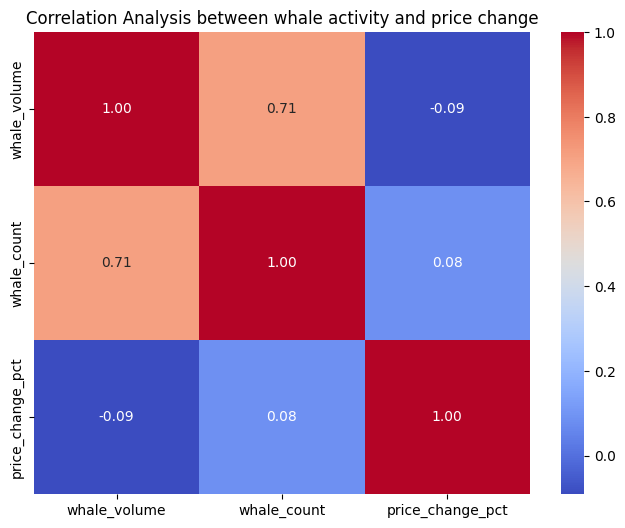

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset of relevant columns
corr = df_merged[['whale_volume', 'whale_count', 'price_change_pct']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Analysis between whale activity and price change")
plt.show()


#### Lag Analysis:

This helps test if whale activity leads price changes (that is, shift in whale activity by 1 day)

In [48]:
df_merged['whale_volume_lag1'] = df_merged['whale_volume'].shift(1)
df_merged['whale_count_lag1'] = df_merged['whale_count'].shift(1)

corr_lag_volume = df_merged['whale_volume_lag1'].corr(df_merged['price_change_pct'])
corr_lag_count = df_merged['whale_count_lag1'].corr(df_merged['price_change_pct'])

print(f"Lag-1 Correlation (whale volume -> next day price change): {corr_lag_volume:.4f}")
print(f"Lag-1 Correlation (whale count -> next day price change): {corr_lag_count:.4f}")


Lag-1 Correlation (whale volume -> next day price change): -0.0157
Lag-1 Correlation (whale count -> next day price change): 0.0930


#### Lag Analysis result:

Lagging whale activity by 1 day, answers the question: 

- Does today's whale activity affects tomorrow's price movement 

    - Whale volume (−0.0157) has essentially zero predictive power on next-day price changes.

    - Whale count (+0.0930) is also not significant, though marginally higher than volume.

There's no strong evidence that whale behavior directly or immediately influences price movements on a daily timescale, at least not linearly.

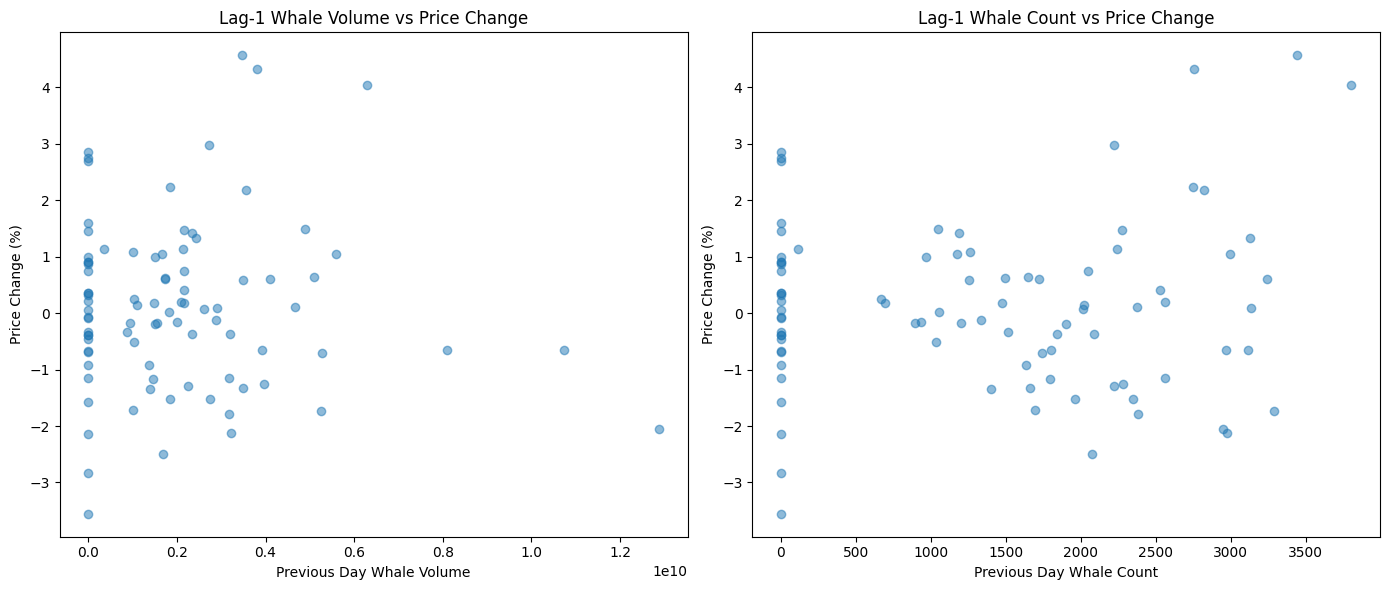

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Lag-1 Whale Volume vs Price Change
plt.subplot(1, 2, 1)
plt.scatter(df_merged['whale_volume_lag1'], df_merged['price_change_pct'], alpha=0.5)
plt.title('Lag-1 Whale Volume vs Price Change')
plt.xlabel('Previous Day Whale Volume')
plt.ylabel('Price Change (%)')

# Lag-1 Whale Count vs Price Change
plt.subplot(1, 2, 2)
plt.scatter(df_merged['whale_count_lag1'], df_merged['price_change_pct'], alpha=0.5)
plt.title('Lag-1 Whale Count vs Price Change')
plt.xlabel('Previous Day Whale Count')
plt.ylabel('Price Change (%)')

plt.tight_layout()
plt.show()


#### Dual - axis plotting in Matplotlib and Seaborn

##### Price vs Whale Volume

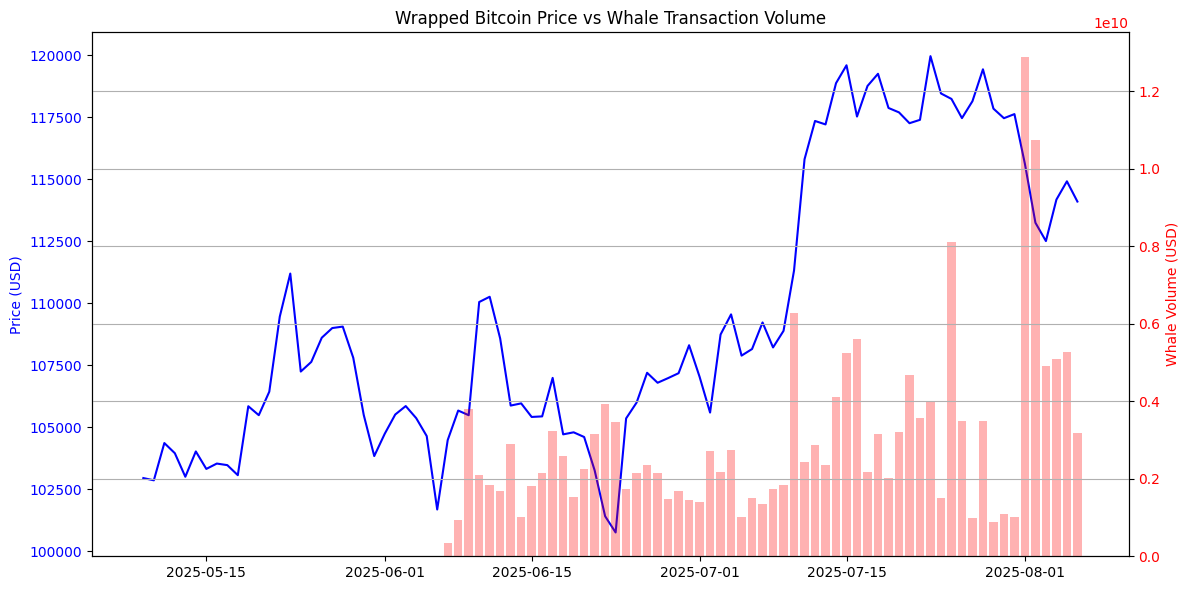

In [50]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_merged['date'], df_merged['price'], color='blue', label='Price (USD)')
ax1.set_ylabel('Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.bar(df_merged['date'], df_merged['whale_volume'], color='red', alpha=0.3, label='Whale Volume')
ax2.set_ylabel('Whale Volume (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Wrapped Bitcoin Price vs Whale Transaction Volume')
plt.grid(True)
plt.tight_layout()
plt.show()


##### The chart shows a dual-axis time series comparing Price vs Whale Volume:

- Left Y-Axis (Blue Line): Wrapped Bitcoin Price (USD) over time

    - This is a line plot showing how the price changes day by day

- Right Y-Axis (Red Bars): Whale Transaction Volume (USD) over time

    - The bars represents the daily total value of large transfers (whale activity), over $100K per transaction, summed per day


##### Whale Volume vs Price Change

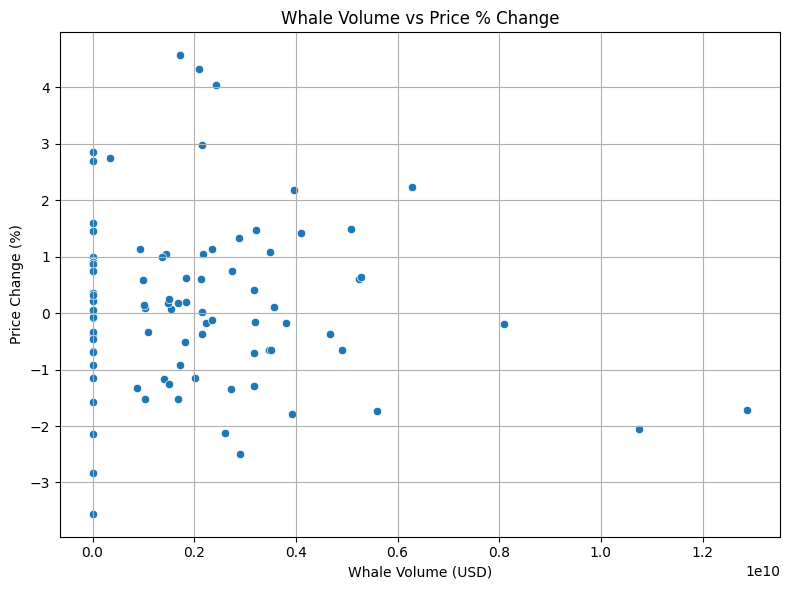

In [51]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_merged, x='whale_volume', y='price_change_pct')
plt.title('Whale Volume vs Price % Change')
plt.xlabel('Whale Volume (USD)')
plt.ylabel('Price Change (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


This scatter plot — “Whale Volume vs Price % Change”, helps to visually assess whether large whale transactions are associated with price movements in Wrapped Bitcoin.

- X-axis: Daily whale transaction volume (in USD)
- Y-axis: Daily percentage change in Wrapped Bitcoin’s price
- Each dot: Represents one day

Most points cluster near the origin shows that most days have low whale volume and small price changes. There are no clear trend line is visible (e.g., upward or downward slope)

High whale volume days (right side of X-axis): Appears to have both positive and negative price changes. This suggests no consistent directional effect (not clearly bullish or bearish)

Low correlation: This confirms there's weak or no linear relationship between whale volume and same-day price change.

##### Calculate Price Volatility

In [52]:
# Calculate daily returns (percentage change)
df_merged['price_return'] = df_merged['price'].pct_change()

# Calculate rolling volatility - e.g., 7-day rolling std dev of returns
df_merged['volatility_7d'] = df_merged['price_return'].rolling(window=7).std() * 100  # in percent

print(df_merged[['date', 'price_return', 'volatility_7d']].tail(10))


         date  price_return  volatility_7d
80 2025-07-28      0.010887       1.144186
81 2025-07-29     -0.013287       1.296424
82 2025-07-30     -0.003271       0.895602
83 2025-07-31      0.001411       0.797009
84 2025-08-01     -0.017101       1.005889
85 2025-08-02     -0.020501       1.203193
86 2025-08-03     -0.006523       1.101972
87 2025-08-04      0.014861       1.213544
88 2025-08-05      0.006462       1.254125
89 2025-08-06     -0.007106       1.261196


##### Adding lagged whale activity features (to test if whales lead volatility)

In [53]:
# Lag whale_volume and whale_count by 1 day

df_merged['whale_volume_lag1'] = df_merged['whale_volume'].shift(1)
df_merged['whale_count_lag1'] = df_merged['whale_count'].shift(1)


#### Correlation between lagged whale activity and volatility

In [54]:
corr_vol_lag_volume = df_merged['whale_volume_lag1'].corr(df_merged['volatility_7d'])
corr_vol_lag_count = df_merged['whale_count_lag1'].corr(df_merged['volatility_7d'])

print(f"Lag-1 Correlation (whale volume -> volatility): {corr_vol_lag_volume:.4f}")
print(f"Lag-1 Correlation (whale count -> volatility): {corr_vol_lag_count:.4f}")


Lag-1 Correlation (whale volume -> volatility): -0.0617
Lag-1 Correlation (whale count -> volatility): 0.0951


##### Lag-1 Correlation Results (Whale Activity -> Next Day Volatility)
- Whale volume → volatility: −0.0617

- Whale count → volatility: +0.0951

    - Whale Volume (has -0.0617 correlation with volatility): Very weak and slightly negative. This implies that a higher whale volume on a given day does not predict higher volatility the next day.

    - Whale Count (has +0.0951 correlation with volatility): Still weak, but slightly positive. This may indicate a small tendency for increased whale activity (number of transactions) to precede minor increases in volatility the next day.

Whale activity (volume or count) does not strongly predict short-term volatility spikes.

##### Whale Activity vs. Volatility

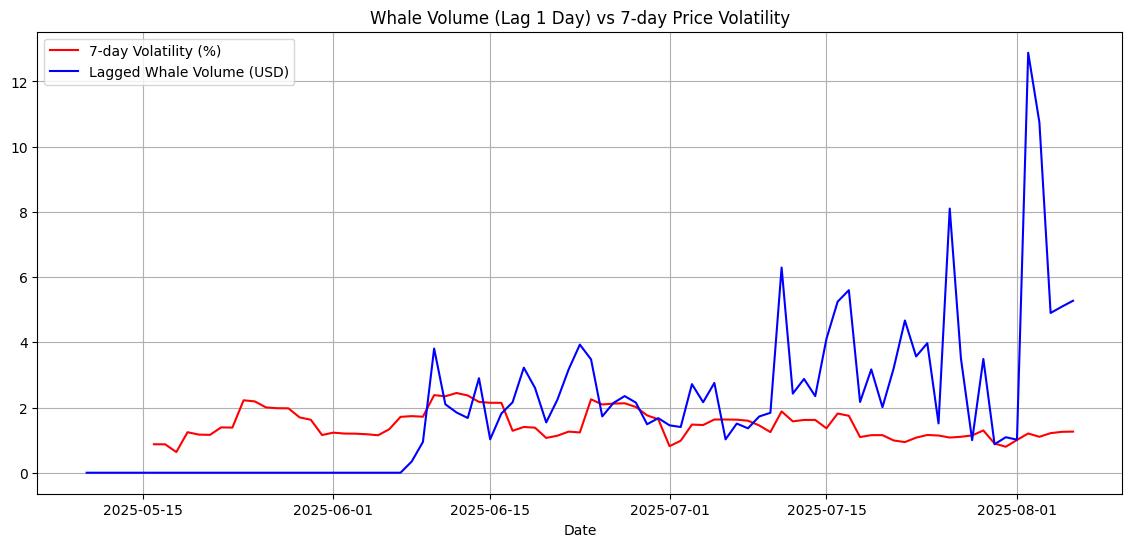

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(df_merged['date'], df_merged['volatility_7d'], label='7-day Volatility (%)', color='red')
plt.plot(df_merged['date'], df_merged['whale_volume_lag1'] / 1e9, label='Lagged Whale Volume (USD)', color='blue')
plt.xlabel('Date')
plt.title('Whale Volume (Lag 1 Day) vs 7-day Price Volatility')
plt.legend()
plt.grid(True)
plt.show()


##### Whale Volume (Lag 1 Day) vs 7-Day Price Volatility
- Red Line: 7-day rolling price volatility (in %).
- Blue Line: Previous day's whale transaction volume (in USD), shifted forward by 1 day to compare with next-day volatility.

    - No Strong Visual Lead-Lag Pattern: The red (volatility) and blue (whale volume) lines don’t consistently move in sync or with a clear lag relationship.
    - Whale Volume Spikes ≠ Volatility Spikes: The largest whale volume spikes (like end of July/early August) don’t lead to major increases in volatility.
    - Volatility Appears More Stable: This implies that market volatility is less reactive to isolated whale movements, at least within the scope of this dataset.

What this means is that whale volume from the previous day doesn’t significantly predict or precede 7-day price volatility.
 
 Both Visual insights and correlation analysis agrees, that whale activity alone is not a good short-term volatility signal.

